# 20211029 (CNN)

5기 Level 1 CNN 자료입니다.

# Contents

1. Preparing Dataset
2. Inspecting Dataset
3. Preprocessing
4. Modeling
5. Visualization
6. 추가적인 팁, 요령
7. Competetion 안내

In [ ]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt #시각화는 pyplot을 쓸일이 많다

from tensorflow.data import Dataset #외부 데이터 아니고 tenserflow데이터 쓸거라 data 가져오고
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical #원활 인코딩 0이면 
from tensorflow.keras.optimizers import Adam, RMSprop #이외에 쓰고싶은거 가져와라 
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization

from einops import rearrange #einops도 쓸예정
from sklearn.model_selection import train_test_split  #set 나눌예정 test train validation 딥러닝에선 validation 필요

# 1. Preparing Dataset

일반적인 데이터는 우리가 직접 폴더에서 불러와야 하지만, MNIST 데이터의 경우 keras에서 제공해주기 때문에 다음과 같이 불러옵니다.

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


# 2. Inspecting Dataset

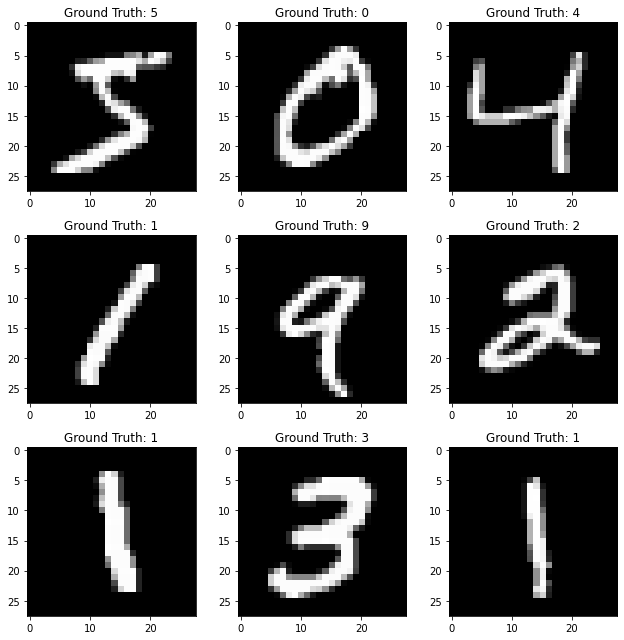

In [ ]:
fig = plt.figure(figsize=(9, 9))

#아래가 시각화 과정

for i in range(9):
    plt.subplot(3, 3, 1 + i) #9개 출력할걸데 어떤 모양으로 출력할것인가? 3*3으로 출력할거라 이런모양
    plt.tight_layout() #안써도됨, 여백이 싫어서 줄이겠다는 함수
    plt.imshow(X_train[i], cmap="gray", interpolation="none") #이미지 보여주는 것, 9개 쭉 돈다.
    target = y_train[i] #실제로 어떤 숫자인지 title을 줄것임 이 그림이 몇인가?
    plt.title("Ground Truth: {}".format(int(target)))  #제목에는 target 값 보여줘라

plt.show()

# 3. Preprocessing

In [ ]:
target_size = 10    # 0 ~ 9, 총 9개 최종 장에서도 10개 여야함
#x_train 자체는  600 28 28 이렇게 되어이씀 흑백이라 걍 그런듯 그래서 l 추가시켜줘야함
### 주의: 흑백 데이터여도 channel 차원을 살려주어야 정상적으로 작동합니다
X_train = rearrange(X_train, "b h w -> b h w 1")
X_test = rearrange(X_test, "b h w -> b h w 1")

#float32를 숫자의 자료형으로 가지고 있으니 변형시켜줘라
X_train = X_train.astype("float32") / (2 ** 8 - 1)   # 255로 scaling
X_test = X_test.astype("float32") / (2 ** 8 - 1)     # 255로 scaling

y_train = to_categorical(y_train, target_size)       # 타겟을 정수로 변환
y_test = to_categorical(y_test, target_size)         # 타겟을 정수로 변환


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
나눠준다. 

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

#차원이 추가된 모습 

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
(48000, 10)
(12000, 10)
(10000, 10)


# 4. Modeling

의도적으로 성능이 낮게 만들었습니다. 이대로 모델을 학습시킬 경우 baseline(기준선)을 충족하지 못합니다.

In [ ]:
inputs = Input(shape=(28, 28, 1)) #사진에 대한 것만 넣어


#한 블럭마다 conv 2d 2번
X = Conv2D(filters=512, kernel_size=(5, 5), padding="Same")(inputs)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = Conv2D(filters=512, kernel_size=(5, 5), padding="Same", activation="relu")(X)
X = Dropout(0.5)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Conv2D(filters=256, kernel_size=(5, 5), padding="Same")(X)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = Conv2D(filters=128, kernel_size=(5, 5), padding="Same", activation="relu")(X)
X = Dropout(0.5)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Conv2D(filters=64, kernel_size=(3, 3), padding="Same")(X)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu")(X)
X = Dropout(0.3)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

#위의 3덩이 끝나고 펼친다
X = Flatten()(X)
X = Dense(1024, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.2)(X)
X = Dense(256, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.2)(X)
outputs = Dense(10, activation="softmax")(X)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 512)       13312     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 512)       2048      
_________________________________________________________________
activation (Activation)      (None, 28, 28, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 512)       6554112   
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 512)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 512)       0     

In [ ]:
model.compile(optimizer=RMSprop(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=256, epochs=15, validation_data=(X_val, y_val), verbose=1)

Epoch 1/15
188/188 [==============================] - 29s 153ms/step - loss: 0.3783 - accuracy: 0.8809 - val_loss: 3.2566 - val_accuracy: 0.0963
Epoch 2/15
188/188 [==============================] - 25s 134ms/step - loss: 0.0782 - accuracy: 0.9759 - val_loss: 3.7629 - val_accuracy: 0.0963
Epoch 3/15
188/188 [==============================] - 25s 134ms/step - loss: 0.0517 - accuracy: 0.9837 - val_loss: 2.3011 - val_accuracy: 0.2338
Epoch 4/15
188/188 [==============================] - 25s 135ms/step - loss: 0.0400 - accuracy: 0.9872 - val_loss: 1.0513 - val_accuracy: 0.6496
Epoch 5/15
188/188 [==============================] - 25s 134ms/step - loss: 0.0328 - accuracy: 0.9898 - val_loss: 0.4604 - val_accuracy: 0.8786
Epoch 6/15
188/188 [==============================] - 25s 135ms/step - loss: 0.0280 - accuracy: 0.9912 - val_loss: 0.4520 - val_accuracy: 0.8508
Epoch 7/15
188/188 [==============================] - 25s 135ms/step - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.5327 - val_ac

In [ ]:
model.evaluate(X_test, y_test, batch_size=256)

40/40 [==============================] - 2s 42ms/step - loss: 0.2347 - accuracy: 0.9295


[0.23468181490898132, 0.9294999837875366]

# 5. Visualization

In [ ]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

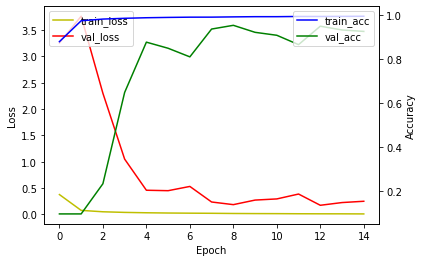

In [ ]:
acc_loss_plot(history)

# 6. 추가적인 팁, 요령

## 6-1. Hyperparameter Tuning

Parameter는 모델이 스스로 학습을 진행하면서 습득하지만, Hyperparameter는 우리가 직접 지정을 해주어야 합니다. 위에서 제가 만든 모델은 임의로, 아무렇게나 쌓은 모델입니다. 즉, Hyperparameter Tuning이 전혀 되어 있지 않습니다. kernel의 size, optimizer의 learning rate, epoch 횟수, batch size, validation의 비율과 같은 변수는 물론이고, Convolution을 몇 번 사용할 것인지, Activation과 Dropout 중 어떤 Layer를 먼저 사용할 것인지, 어떠한 종류의 Optimizer를 사용할 것인지와 같은 부분까지 조절해가면서, 우리의 데이터에 맞는 적절한 모델을 찾아야 합니다.

어떠한 순서대로 할지는 본인의 선택이지만, 저는 learning rate와 관련된 부분들(optimizer, learning rate scheduler 등)을 우선적으로 잡습니다.

## 6-2. Callback Functions

지난 과제에서 언급하였던 Callback Functions입니다. 일정 epoch 이상 loss가 떨어지지 않거나 acc가 증가하지 않으면 학습을 멈추는 early stopping, 학습하면서 성능이 좋았던 모델을 저장하여 나중에 불러올 수 있도록 하는 model checkpoint, 학습 도중 learning rate를 조절할 수 있는 learning rate scheduler와 같은 다양한 함수들이 있습니다. 본인의 취향에 맞게, 또 데이터의 특성에 맞게 callback functions를 활용해봅시다.

## 6-3. Ensemble

여러 개의 모델을 training한 후, voting 등을 통하여 최종 output을 결정할 수도 있습니다. 물론, 하나의 모델로 99% 이상의 accuracy가 나오기도 하기 때문에 유의미한 정확도 향상을 체감하기는 어렵겠지만, 이러한 상황에서 0.01% 향상은 상당히 중요하기도 합니다.

# 7. Competetion 안내

일정: ~ 11월 12일 (금요일)

* 11월 5일(금요일)에는 중간과정 공유, 11월 12일(금요일)에는 최종 발표 <br>
(발표 자료는 .ppt, .ipynb, .pdf 등 자유롭게 하시면 됩니다.)
* 11월 3일(수요일)과 11월 10일(수요일)에는 전체 세션 대신 조별 토의 진행 <br>
(조원 간 토의 하에 토의 일정을 조정하여도 괜찮습니다.)

조 구성: 세션 종료 후 슬랙을 통하여 공지

* 한 조에 5기 4명 + 4기(교육팀 멘토) 1명으로 구성
* 조는 전공, 면접 내용, 숙련도 등을 종합적으로 고려하여 결정
* 조원끼리 의논해보다가 해결되지 않는 사항들이 생기면 멘토에게 물어보세요!
* 코드는 GitHub를 통해서 공유할 예정이며, 각 조에 해당하는 GitHub Repository에 초대될 예정

규칙:

1. Keras에서 제공하는 데이터를 사용하여야 합니다. Kaggle 등 외부에서 제공하는 데이터를 사용하지 말아주세요.
2. 학습 결과가 좋게 나오는 특정 seed로 random state를 고정하거나, 잘 나올 때까지 동일한 상태에서 학습을 진행하는 등 연구윤리에 어긋나는 행동은 지양해주세요.
3. test data가 공개되어 있는 상황이지만, 현실 세계에는 test data가 없습니다. Hyperparameter를 조정할 때에는 train, validation data의 결과를 보고 조정해야 합니다. <br>
test data의 결과를 보고 hyperparameter tuning을 하는 행위 역시 지양하여야 합니다.
4. 유명한 dataset이므로, 이미 수많은 자료들이 인터넷에 공개되어 있습니다. 가져다 사용하셔도 좋지만, 적어도 발표 때에는 설명할 수 있는 수준으로 해당 코드를 이해하고 있어야 합니다.
5. Baseline(기준)은 Test Accuracy 99.25%입니다. (위의 모델을 그대로 사용하시면 맞추기 어려울 것입니다.)